<a href="https://colab.research.google.com/github/ioannis-vm/RID_Project_Colab/blob/main/plot_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In persuit of an improved RID|PID model.

Created: `Tue May 21 04:19:25 PM PDT 2024`

With this notebook we superimpose rolling quantiles from RID|PID
models on top of structural analysis results of 18 steel archetype
buildings. Each building is represented by two separate 2D OpenSees
models which only differ to a small degree in their number of gravity
framing bays. We analyzed them under 18 hazard levels with Conditional
Spectrum (CS) suites of 40 records. The targets were RotD50, and the
two horizontal ground motion records were applied to the corresponding
model. Because the distribution of the RID-PID pairs is very similar
in the two directions, we merge the RID-PID pairs of each direction in
the figures and represent their distribution using the same model.

The conditional Weibull model is dynamically fitted to the data.
The FEMA P-58 and SP3 models are superimposed with predefined
parameters.

## Initial Google Colab-specific setup

In [ ]:
# Install `git` and clone our repo.
!apt-get install git
!git clone https://github.com/ioannis-vm/RID_Project_Colab

In [ ]:
# Change directory to the repo
import os
os.chdir('RID_Project_Colab')

In [ ]:
# Install project dependencies
!pip install -r requirements.txt

### Setup

In [ ]:
# Imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
from src import models
from src.importable import generate_plot

In [ ]:
# Select case, set model parameters

# Simple and powerful.
selected_model = models.Model_1_Weibull()
# More flexible, still work in progress.
# selected_model = models.Model_Weibull_Trilinear()

# Structural system:
# any of {'smrf', 'scbf', 'brbf'}

# Total number of stories:
# any of {'3', '6', '9'}

# Design risk category:
# any of {'ii', 'iv'}

# Story:
# any of {'1', '2', ...} or 'max-max'

# system, stories, rc, story = 'smrf', '3', 'ii', '1'
# system, stories, rc, story = 'smrf', '3', 'ii', '2'
# system, stories, rc, story = 'smrf', '3', 'ii', '3'

system, stories, rc, story = 'scbf', '3', 'ii', 'max-max'

# Stratification criterion, only applicable when story='max-max'.
# 'StoryDiffText': Difference in story where maxPID/maxRID occur.
# 'PIDStoryText':  Story where max PID occurs.
# 'RIDStoryText':  Story where max RID occurs.

criterion = 'StoryDiffText'
# criterion = 'PIDStoryText'
# criterion = 'RIDStoryText'

In [ ]:
df = pd.read_parquet('data/edps.parquet')
df.index = df.index.reorder_levels(['archetype', 'dir', 'edp', 'hz', 'gm', 'loc'])
df = df.sort_index()

# FEMA P-58 model parameters
fema_delta_y = 0.01
fema_dispersion = 0.80

# SP3 model parameters
sp3_delta_y = {'smrf': 0.01, 'scbf': 0.003, 'brbf': 0.0021}[system]
sp3_type = {
    'smrf': 'general',
    'scbf': 'general',
    'brbf': 'brbf_no_backup_grav',
}[system]
sp3_dispersion = 0.80

# bypass SP3 defaults:
# sp3_delta_y = 0.003
# sp3_type = 'general'
# # any of
# # {elastic, general, brbf_no_backup, brbf_no_backup_grav, brbf_backup}

# Residual drift fragility curve (for probabilities)
rid_capacity_delta = 0.01
rid_capacity_beta = 0.3

In [ ]:
# plotting parameters
xmin, xmax = -0.002, 0.02  # rid
ymin, ymax = -0.002, 0.065  # pid

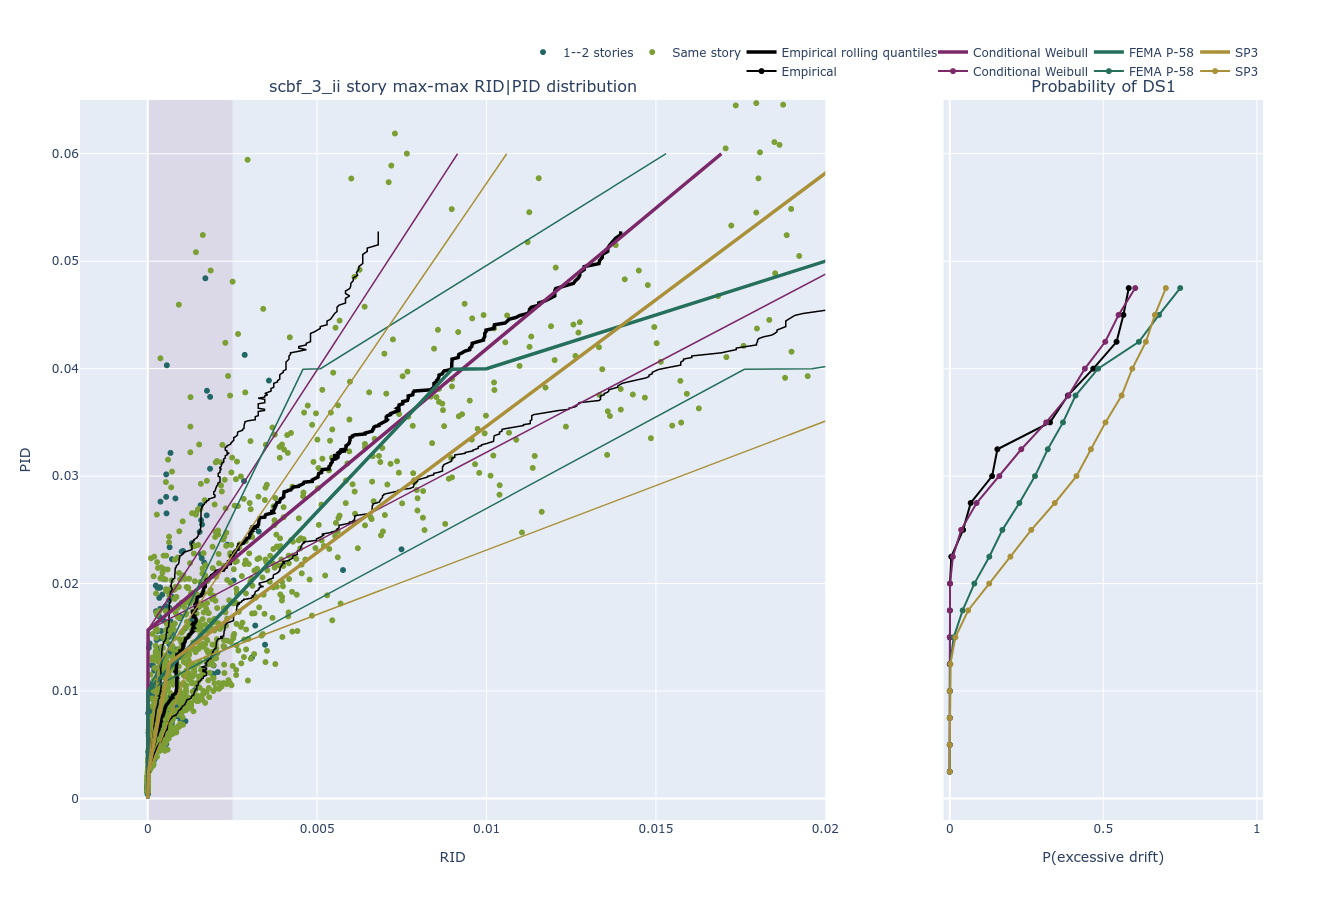

In [ ]:
generate_plot(
    df,
    selected_model,
    system,
    stories,
    rc,
    story,
    criterion,
    fema_delta_y,
    fema_dispersion,
    sp3_delta_y,
    sp3_type,
    sp3_dispersion,
    rid_capacity_delta,
    rid_capacity_beta,
    xmin, xmax, ymin, ymax
)